## Importing Libraries

In [2]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import nrrd
from ipywidgets import interact, IntSlider
import numpy as np
import os
import cv2

# Reading the nrrd file

In [3]:
def read_grayscale_image_cv2(nrrd_file_path):
    # Load the NRRD file using SimpleITK
    image_sitk = sitk.ReadImage(nrrd_file_path)

    # Check if the image is already grayscale (single channel)
    if image_sitk.GetNumberOfComponentsPerPixel() == 1:
        # Extract the image data as a NumPy array
        image_data = sitk.GetArrayFromImage(image_sitk)
    else:
        # Convert the image to grayscale using SimpleITK
        image_sitk = sitk.Cast(sitk.RescaleIntensity(image_sitk), sitk.sitkUInt8)
        # Extract the image data as a NumPy array
        image_data = sitk.GetArrayFromImage(image_sitk)

    return image_data

In [3]:
# Read for single nrrd file
nrrd_file_path = '../006.nrrd'
grayscale_image_cv2 = read_grayscale_image_cv2(nrrd_file_path)

len(grayscale_image_cv2)

579

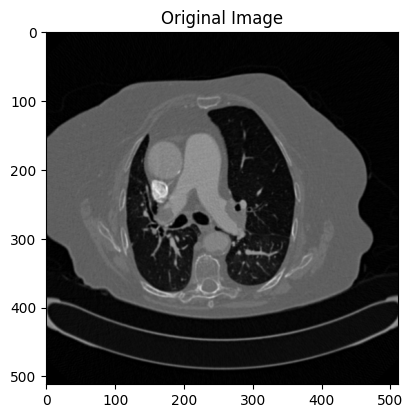

In [4]:
# Create a figure with subplots
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
 
# Add the original image as the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(grayscale_image_cv2[349], cmap='gray')
plt.title('Original Image')
plt.show()

## MAIN

In [18]:
# Function to save each rotated image slice with OpenCV thresholding mimicking np.clip
def save_rotated_slices_with_opencv_threshold(nrrd_file_path, output_folder, lower_bound, upper_bound):
    # Read the NRRD file
    data, header = nrrd.read(nrrd_file_path)
    data_rotated = np.rot90(data, axes=(1, 0))  # Apply rotation

    # Ensure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Process and save each rotated slice
    for slice_number in range(data_rotated.shape[2]):
        slice_data = data_rotated[:, :, slice_number]

        # Apply lower bound threshold
        _, lower_thresh = cv2.threshold(slice_data, lower_bound, 255, cv2.THRESH_TOZERO)

        # Apply upper bound threshold (inverting the image first)
        inverted_img = 255 - lower_thresh
        _, upper_thresh_inv = cv2.threshold(inverted_img, 255 - upper_bound, 255, cv2.THRESH_TOZERO)
        processed_slice = 255 - upper_thresh_inv

        # Save the processed slice
        plt.imsave(os.path.join(output_folder, f"slice_{slice_number}.png"), processed_slice, cmap='gray')

# Example usage

nrrd_file_path = 'patients_nrrd/007.nrrd'
output_folder = 'patient_007'
save_rotated_slices_with_opencv_threshold(nrrd_file_path, output_folder, lower_bound=142-730/2, upper_bound=142+730/2)



-------------------------------------------------------------

# Open image in grayscale

In [6]:
image_path = "processed_rotated_slices_opencv_threshold/slice_341.png"  # set image path
final_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

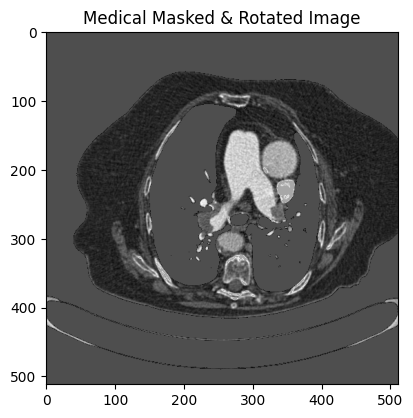

In [7]:
# Create a figure with subplots
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
 
# Add the original image as the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(final_image, cmap='gray')
plt.title('Medical Masked & Rotated Image')
plt.show()

In [8]:
hist , bins = np.histogram(final_image.flatten(), 256, [0,256])

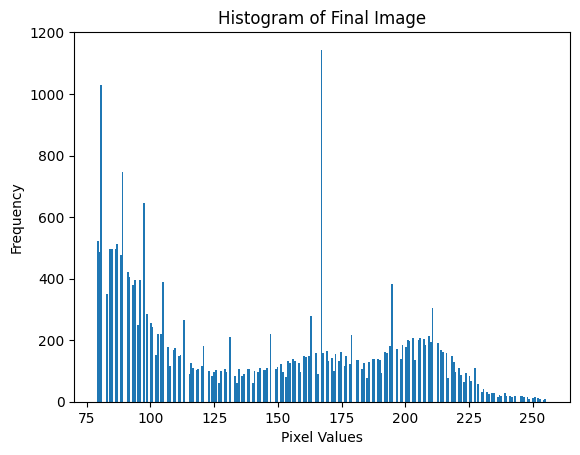

In [9]:
plt.hist(final_image.flatten(), 256, [79, 256])
plt.title('Histogram of Final Image')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.show()

In [10]:
hist, bins = np.histogram(final_image, 256, [175,256])
 
count_over130 = np.sum(hist)
print(count_over130)

8203


In [12]:
img_list = []

for i in range(578):
    img = cv2.imread(f'processed_rotated_slices_opencv_threshold/slice_{i}.png',0)
    hist, bins = np.histogram(img.flatten(), 256, [175,256])
    count_over130 = np.sum(hist)
    if int(count_over130) > (8785 - (8785*0.090)):
        img_list.append(i)

In [13]:
img_list

[340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355]

In [22]:
for i in img_list:
    img = cv2.imread(f'processed_rotated_slices_opencv_threshold/slice_{i}.png',0)

    final_thresh_image,thresh1=cv2.threshold(img,115,255,cv2.THRESH_BINARY)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh1)
    largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+1
    largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255

    kernel = np.ones((3, 3), np.uint8)

    # Erosion (y rounds)
    erosed_image = cv2.erode(largest_component_mask, kernel, iterations=2)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(erosed_image)
    largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+1
    largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255

    dilated_image = largest_component_mask
    dilated_image = cv2.dilate(dilated_image, kernel, iterations=8)

    result_image = img.copy()
    result_image[dilated_image == 0] = 0

    blur = cv2.GaussianBlur(result_image,(5,5),0)

    new_mask = cv2.inRange(blur, 90, 120)

    erosed_image = cv2.erode(new_mask, kernel, iterations=1)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(erosed_image)
    largest_component_indices = np.argsort(stats[1:, cv2.CC_STAT_AREA])[::-1][:2] + 1
    first_two_components_mask = np.zeros_like(labels, dtype=np.uint8)

    for index in largest_component_indices:
        first_two_components_mask[labels == index] = 255

    dilated_image = first_two_components_mask

    dilated_image = cv2.dilate(dilated_image, kernel, iterations=2)

    rgb_image = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    colored_image = rgb_image.copy()
    color = (0, 0, 255)  # BGR format (red)

    # Iterate through the pixels of the mask image
    for y in range(dilated_image.shape[0]):
        for x in range(dilated_image.shape[1]):
            if dilated_image[y, x] > 0:
                # If the mask pixel is not black, apply the color to the corresponding pixel in the original image
                colored_image[y, x] = color

    # Display or save the resulting image with painted components
    cv2.imwrite(f'colored_image{i}.png', colored_image)
    cv2.imshow('Colored', colored_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
img_list = []


patient = '11'
slices = os.listdir(f'Patient{patient}_processed_rotated_slices_opencv_threshold')

for i in range(len(slices)):
    img = cv2.imread(f'Patient{patient}_processed_rotated_slices_opencv_threshold/slice_{i}.png',0)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(img, (31, 31), 2)
    
    start = 0.25
    end = 0.75
    cropped = blurred.copy()[int(blurred.shape[1]*(start)):int(blurred.shape[1]*(end-0.15)), int(blurred.shape[0]*(start)):int(blurred.shape[0]*end)]

    # Detect circles using HoughCircles
    # Adjust these parameters for the specific image
    circles = cv2.HoughCircles(cropped, cv2.HOUGH_GRADIENT, dp=1, minDist=100,
                               param1=30, param2=35, minRadius=20, maxRadius=35)
     
    # If circles are detected, draw them
    if circles is not None:
        img_list.append(i)
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            cv2.circle(final_image, (x, y), r, (0, 255, 0), 4)

In [ ]:
cropped = final_image.copy()[int(final_image.shape[1]*(start)):int(final_image.shape[1]*(end-0.15)), int(final_image.shape[0]*(start)):int(final_image.shape[0]*end)]
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
#img.copy()[y:y+h, x:x+w]

# Add the original image as the first subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot
plt.imshow(cropped, cmap='gray')
plt.title('Cropped Image')
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(final_image, cmap='gray')
plt.title('Original Image')
plt.show()

In [ ]:
# Function to update the circle detection whenever trackbars are used
def detect_circles(x):
    # Get current trackbar positions
    dp = cv2.getTrackbarPos('dp', 'Detected Circles')
    minDist = cv2.getTrackbarPos('minDist', 'Detected Circles')
    param1 = cv2.getTrackbarPos('param1', 'Detected Circles')
    param2 = cv2.getTrackbarPos('param2', 'Detected Circles')
    minRadius = cv2.getTrackbarPos('minRadius', 'Detected Circles')
    maxRadius = cv2.getTrackbarPos('maxRadius', 'Detected Circles')
    
    # Detect circles using the current trackbar values
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=dp, minDist=minDist,
                               param1=param1, param2=param2, 
                               minRadius=minRadius, maxRadius=maxRadius)
    
    # Copy the original image to avoid drawing over it
    displayed_image = image.copy()
    
    # If circles are detected, draw them
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            cv2.circle(displayed_image, (x, y), r, (0, 255, 0), 4)
    
    # Display the image with detected circles
    cv2.imshow('Detected Circles', displayed_image)

# Load the image from file system
image_path = "processed_rotated_slices_opencv_threshold/slice_341.png"  # set image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur
blurred = cv2.GaussianBlur(image, (9, 9), 2)

# Create a window to attach trackbars
cv2.namedWindow('Detected Circles')

# Create trackbars for circle detection parameters
cv2.createTrackbar('dp', 'Detected Circles', 1, 5, detect_circles)
cv2.createTrackbar('minDist', 'Detected Circles', 100, 500, detect_circles)
cv2.createTrackbar('param1', 'Detected Circles', 50, 100, detect_circles)
cv2.createTrackbar('param2', 'Detected Circles', 30, 100, detect_circles)
cv2.createTrackbar('minRadius', 'Detected Circles', 0, 100, detect_circles)
cv2.createTrackbar('maxRadius', 'Detected Circles', 0, 200, detect_circles)

# Initialize the window with the first circle detection
detect_circles(0)

# Wait indefinitely until a key is pressed
cv2.waitKey(0)

# Destroy all windows
cv2.destroyAllWindows()

## Final_Analysis: Patient 6 - Slice 340

# equalisation 

TypeError: Image data of dtype object cannot be converted to float

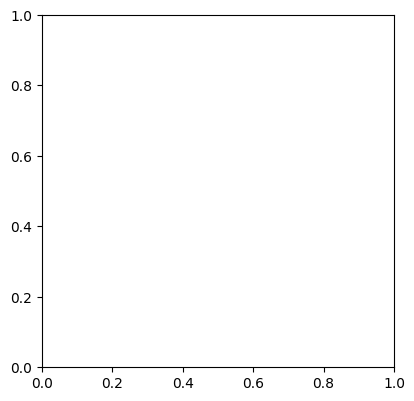

In [4]:
patient = 6
slice_n = 340

image_340 = cv2.imread(f'patient_{patient}/slice_{slice_n}.png',0)

equalized_image = cv2.equalizeHist(image_340)
 
# Create a figure with subplots
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
 
# Add the original image as the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(image_340, cmap='gray')
plt.title('Original Image')
plt.show()
 
# Add the original image as the first subplot
plt.subplot(1, 1, 1)  # 1 row, 1 columns, first subplot
plt.imshow(equalized_image, cmap='gray')
plt.title('Equalized Image')
 
plt.show()

##Edge detection

In [ ]:
# Edge Detection (using Canny)
edges = cv2.Canny(equalized_image, 10, 50)  #one more parameter chaning the mask
#show_image_with_waitkey(edges, "Edge Detection T: x, H: y")

# Edge Detection (using Canny)
edges_no_equal = cv2.Canny(final_image, 10, 50)  #one more parameter chaning the mask
#show_image_with_waitkey(edges, "Edge Detection T: x, H: y")

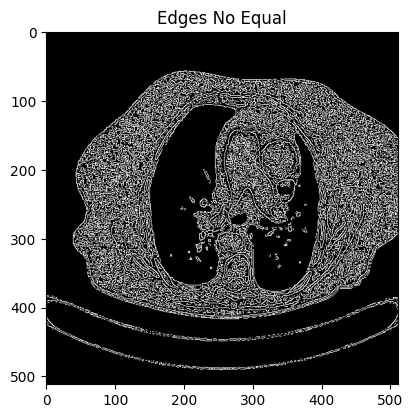

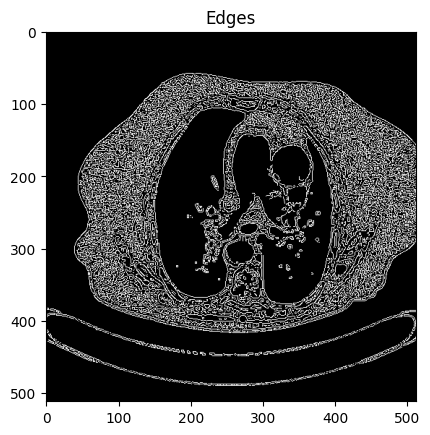

In [ ]:
# Convert the images from BGR to RGB format (matplotlib uses RGB)
#img_print = cv2.cvtColor(edges,cv2.IMREAD_GRAYSCALE)
 
# Create a figure with subplots
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
 
# Add the original image as the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(edges_no_equal, cmap='gray')
plt.title('Edges No Equal')
plt.show()
 
# Add the original image as the first subplot
plt.subplot(1, 1, 1)  # 1 row, 2 columns, first subplot
plt.imshow(edges, cmap='gray')
plt.title('Edges')
plt.show()

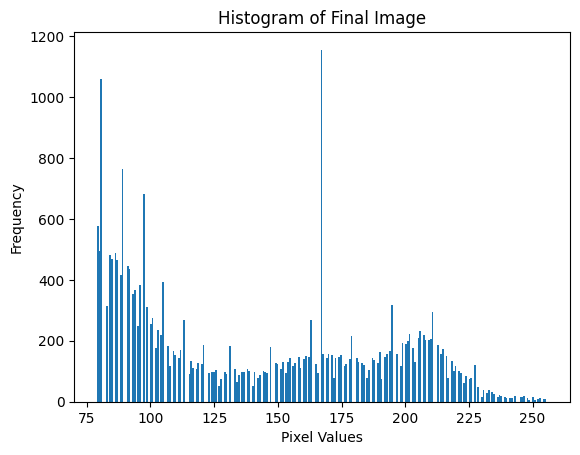

In [ ]:
image_path = "processed_rotated_slices_opencv_threshold/slice_340.png"  # set image path
image_340 = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
hist , bins = np.histogram(image_340.flatten(), 256, [0,256])

plt.hist(image_340.flatten(), 256, [79, 256])
plt.title('Histogram of Final Image')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.show()

In [ ]:
final_thresh_image,thresh1=cv2.threshold(final_image,115,255,cv2.THRESH_BINARY)

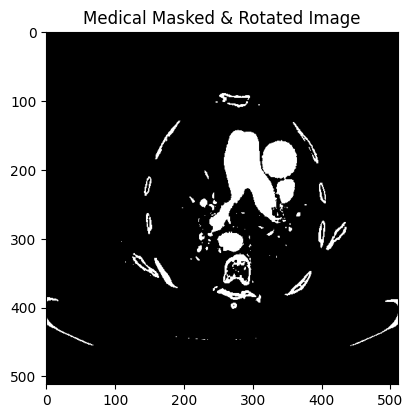

In [ ]:
# Create a figure with subplots
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
 
# Add the original image as the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(thresh1, cmap='gray')
plt.title('Medical Masked & Rotated Image')
plt.show()

In [ ]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh1)

In [ ]:
# Find the largest non-black component
largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+1
print('largest_component_index \n', largest_component_index)

largest_component_index 
 7


In [ ]:
largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255

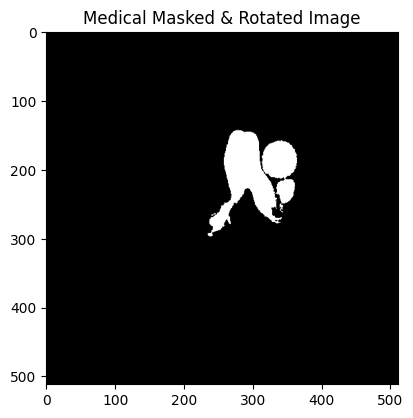

In [ ]:
# Create a figure with subplots
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
 
# Add the original image as the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(largest_component_mask, cmap='gray')
plt.title('Medical Masked & Rotated Image')
plt.show()

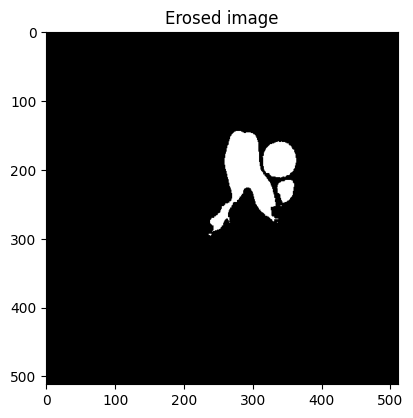

In [ ]:
kernel = np.ones((3, 3), np.uint8)
# Erosion (y rounds)
for _ in range(2):
    erosed_image = cv2.erode(largest_component_mask, kernel, iterations=1)
#show_image_with_waitkey(dilated_image, "3 Rounds of Erosion")

# Create a figure with subplots
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
 
# Add the original image as the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(erosed_image, cmap='gray')
plt.title('Erosed image')
plt.show()

largest_component_index 
 1


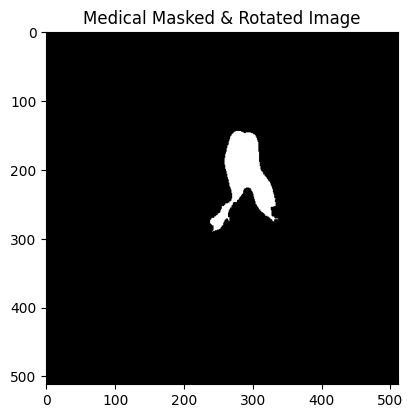

In [ ]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(erosed_image)

# Find the largest non-black component
largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+1
print('largest_component_index \n', largest_component_index)

largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255

# Create a figure with subplots
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
 
# Add the original image as the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(largest_component_mask, cmap='gray')
plt.title('Medical Masked & Rotated Image')
plt.show()

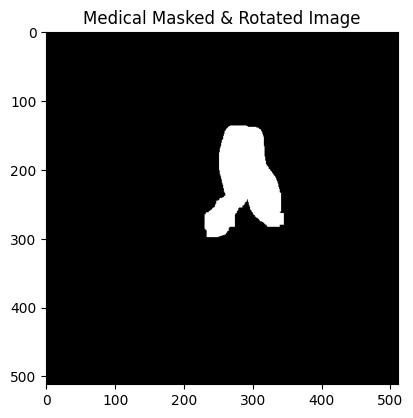

In [ ]:
# Dilation
#kernel = np.ones((5, 5), np.uint8)
kernel = np.ones((3, 3), np.uint8)
dilated_image = largest_component_mask
for _ in range(8):
    dilated_image = cv2.dilate(dilated_image, kernel, iterations=1)
#show_image_with_waitkey(dilated_image, "3 Rounds of Dilation")

# Create a figure with subplots
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
 
# Add the original image as the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(dilated_image, cmap='gray')
plt.title('Medical Masked & Rotated Image')
plt.show()

In [ ]:
result_image = final_image
result_image[dilated_image == 0] = 0

plt.imshow(result_image, cmap='gray')
plt.title('Largest Component')
plt.show()


-1

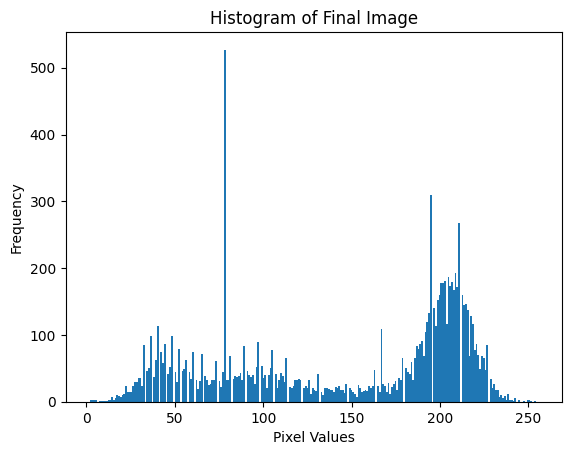

In [ ]:
hist , bins = np.histogram(result_image.flatten(), 256, [0,256])

plt.hist(result_image.flatten(), 256, [1, 256])
plt.title('Histogram of Final Image')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.show()

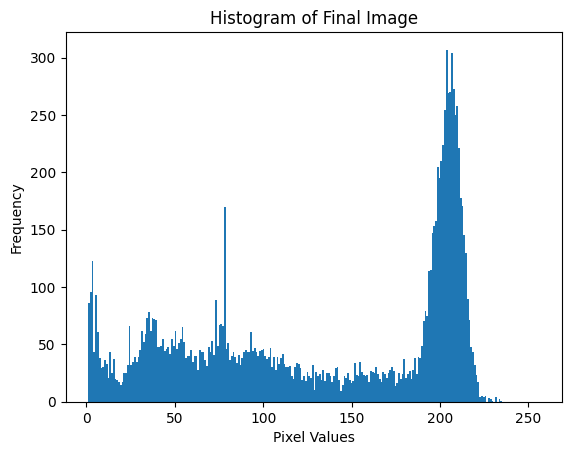

In [ ]:
blur = cv2.GaussianBlur(result_image,(5,5),0)

plt.hist(blur.flatten(), 256, [1, 256])
plt.title('Histogram of Final Image')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.show()

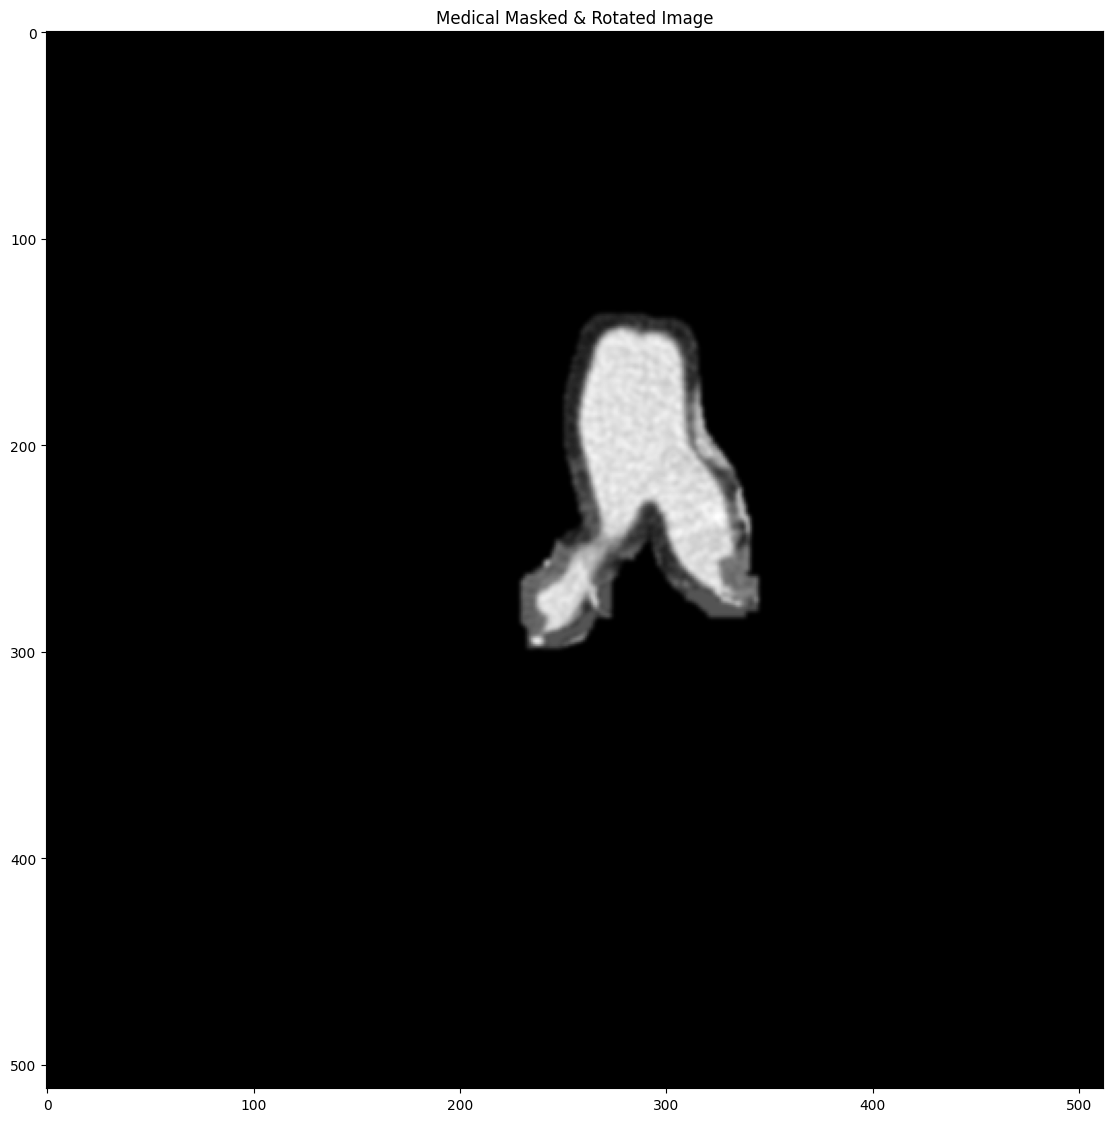

In [ ]:
# Create a figure with subplots
plt.figure(figsize=(30, 30))  # Adjust the figure size as needed

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(blur, cmap='gray')
plt.title('Medical Masked & Rotated Image')
plt.show()

In [ ]:
new_mask = cv2.inRange(blur, 90, 120)

plt.imshow(new_mask, cmap='gray')
plt.title('NEED TITLE')
plt.show()


-1

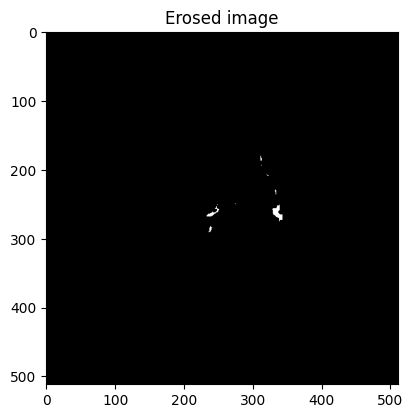

In [ ]:
kernel = np.ones((3, 3), np.uint8)
# Erosion (y rounds)
for _ in range(1):
    erosed_image = cv2.erode(new_mask, kernel, iterations=1)
#show_image_with_waitkey(dilated_image, "3 Rounds of Erosion")

# Create a figure with subplots
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
 
# Add the original image as the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(erosed_image, cmap='gray')
plt.title('Erosed image')
plt.show()

Indices of the first two largest components: [7 8]


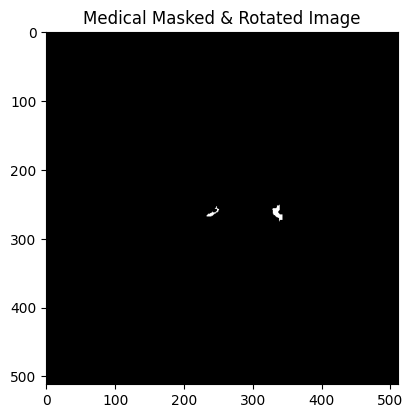

In [ ]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(erosed_image)

# Find the largest (2)non-black component
largest_component_indices = np.argsort(stats[1:, cv2.CC_STAT_AREA])[::-1][:2] + 1
print('Indices of the first two largest components:', largest_component_indices)

# Create masks for the first two largest components
first_two_components_mask = np.zeros_like(labels, dtype=np.uint8)
for index in largest_component_indices:
    first_two_components_mask[labels == index] = 255

# Create a figure with subplots
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
 
# Add the original image as the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(first_two_components_mask, cmap='gray')
plt.title('Medical Masked & Rotated Image')
plt.show()

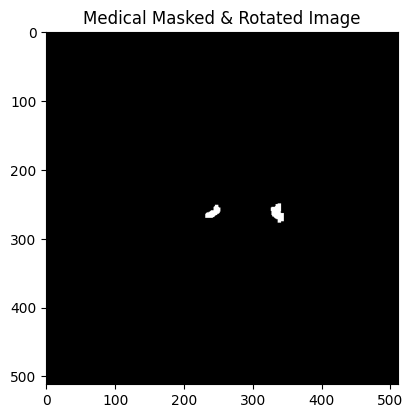

In [ ]:
# Dilation
#kernel = np.ones((5, 5), np.uint8)
kernel = np.ones((3, 3), np.uint8)
dilated_image = first_two_components_mask
for _ in range(2):
    dilated_image = cv2.dilate(dilated_image, kernel, iterations=1)
#show_image_with_waitkey(dilated_image, "3 Rounds of Dilation")

# Create a figure with subplots
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
 
# Add the original image as the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(dilated_image, cmap='gray')
plt.title('Medical Masked & Rotated Image')
plt.show()

In [ ]:
image_path = "processed_rotated_slices_opencv_threshold/slice_341.png"  # set image path
final_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

rgb_image = cv2.cvtColor(final_image, cv2.COLOR_GRAY2RGB)
# Create a copy of the original image to preserve the 
colored_image = rgb_image.copy()
color = (0, 0, 255)  # BGR format (red)

# Iterate through the pixels of the mask image
for y in range(dilated_image.shape[0]):
    for x in range(dilated_image.shape[1]):
        if dilated_image[y, x] > 0:
            # If the mask pixel is not black, apply the color to the corresponding pixel in the original image
            colored_image[y, x] = color

# Display or save the resulting image with painted components
cv2.imshow('Colored', colored_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# Edge Detection (using Canny)
edges = cv2.Canny(blur, 100, 150) #οe parameter chaning the mask
#show_image_with_waitkey(edges, "Edge Detection T: x, H: y")

# Edge Detection (using Canny)
edges_no_equal = cv2.Canny(result_image, 100, 80)#one more parameter chaning the mask
#show_image_with_waitkey(edges, "Edge Detection T: x, H: y")

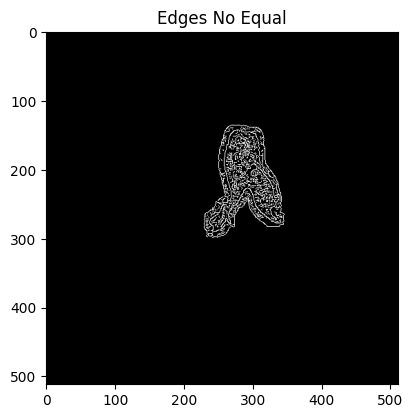

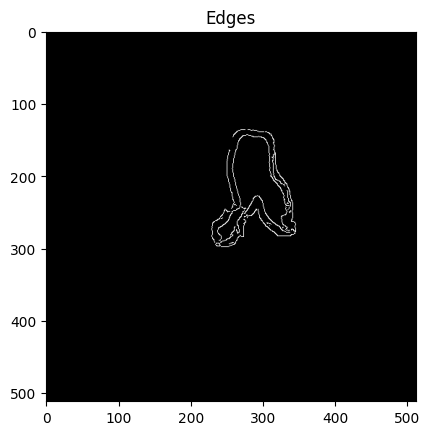

In [ ]:
# Create a figure with subplots
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
 
# Add the original image as the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(edges_no_equal, cmap='gray')
plt.title('Edges No Equal')
plt.show()
 
# Add the original image as the first subplot
plt.subplot(1, 1, 1)  # 1 row, 2 columns, first subplot
plt.imshow(edges, cmap='gray')
plt.title('Edges')
plt.show()

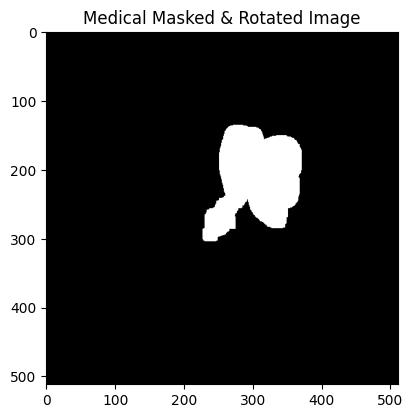

In [ ]:
# Dilation
#kernel = np.ones((5, 5), np.uint8)
kernel = np.ones((3, 3), np.uint8)
dilated_image = largest_component_mask
for _ in range(7):
    dilated_image = cv2.dilate(dilated_image, kernel, iterations=1)
#show_image_with_waitkey(dilated_image, "3 Rounds of Dilation")

# Create a figure with subplots
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
 
# Add the original image as the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(dilated_image, cmap='gray')
plt.title('Medical Masked & Rotated Image')
plt.show()

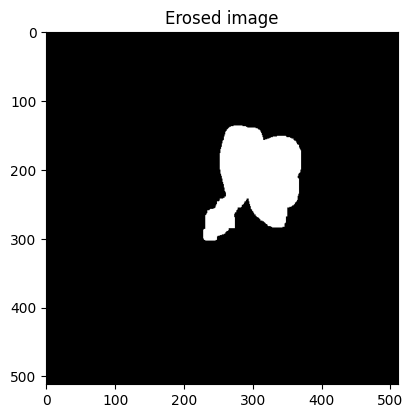

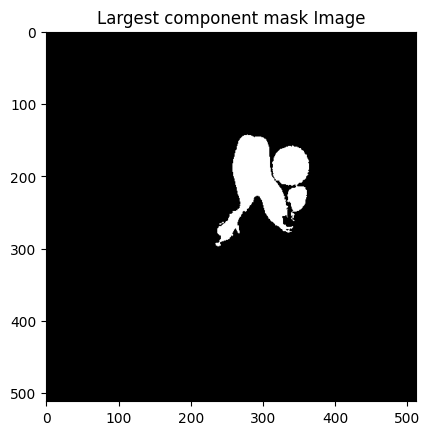

In [ ]:
# Erosion (y rounds)
for _ in range(3):
    erosed_image = cv2.erode(dilated_image, kernel, iterations=1)
#show_image_with_waitkey(dilated_image, "3 Rounds of Erosion")

# Create a figure with subplots
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
 
# Add the original image as the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(erosed_image, cmap='gray')
plt.title('Erosed image')
plt.show()

# Add the original image as the first subplot
plt.subplot(1, 1, 1)  # 1 row, 2 columns, first subplot
plt.imshow(largest_component_mask, cmap='gray')
plt.title('Largest component mask Image')
plt.show()

In [ ]:
result_image = final_image
result_image[erosed_image == 0] = 0
cv2.imshow('Largest Component', result_image)
cv2.waitKey(0)

# continue

# ADAPTIVE THRESHOLDING

In [ ]:
adaptive_thresholded = cv2.adaptiveThreshold(final_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 127, 0)

In [ ]:
def nothing(x):
    pass

image_path = "Patient6_processed_rotated_slices_opencv_threshold/slice_341.png"  # set image path
final_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

cv2.namedWindow('image')

cv2.createTrackbar('Block Size', 'image', 9, 1555, nothing)
cv2.createTrackbar('Constant', 'image', 2, 100, nothing)

while True:
    block_size = cv2.getTrackbarPos('Block Size', 'image')
    constant = cv2.getTrackbarPos('Constant', 'image')

    is_odd = False
    if block_size % 2 == 1:
        is_odd = True

    # Only update the block size if it's an odd number
    if is_odd:
        # Apply adaptive thresholding
        adaptive_thresholded = cv2.adaptiveThreshold(final_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, constant)

        cv2.imshow('image', adaptive_thresholded)

    # Check for ESC key press to exit
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break

cv2.destroyAllWindows()


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:2561: error: (-27:Null pointer) NULL window: 'image' in function 'cvGetTrackbarPos'


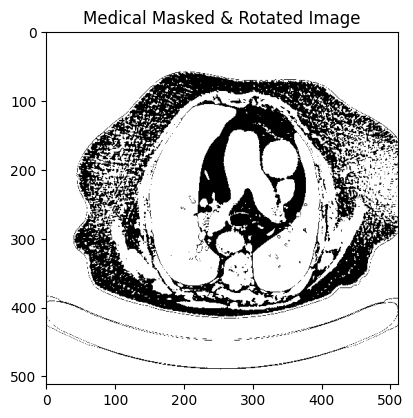

In [ ]:
# Create a figure with subplots
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
 
# Add the original image as the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(adaptive_thresholded, cmap='gray')
plt.title('Medical Masked & Rotated Image')
plt.show()

In [ ]:
hist , bins = np.histogram(final_image.flatten(), 256, [0,256])

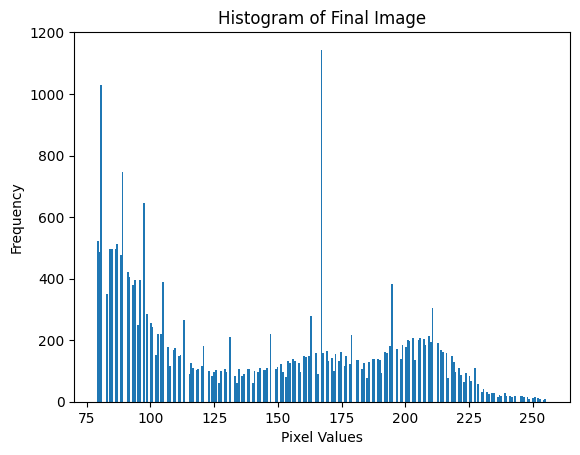

In [ ]:
plt.hist(final_image.flatten(), 256, [79, 256])
plt.title('Histogram of Final Image')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.show()

In [ ]:
hist, bins = np.histogram(final_image, 256, [175,256])
 
count_over130 = np.sum(hist)
print(count_over130)

8203


In [ ]:
type(count_over130)

numpy.int64

In [ ]:
img_list = []

for i in range(578):
    img = cv2.imread(f'processed_rotated_slices_opencv_threshold/slice_{i}.png',0)
    hist, bins = np.histogram(img.flatten(), 256, [175,256])
    count_over130 = np.sum(hist)
    if int(count_over130) > (8785 - (8785*0.090)):
        img_list.append(i)

In [ ]:
img_list

[340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355]

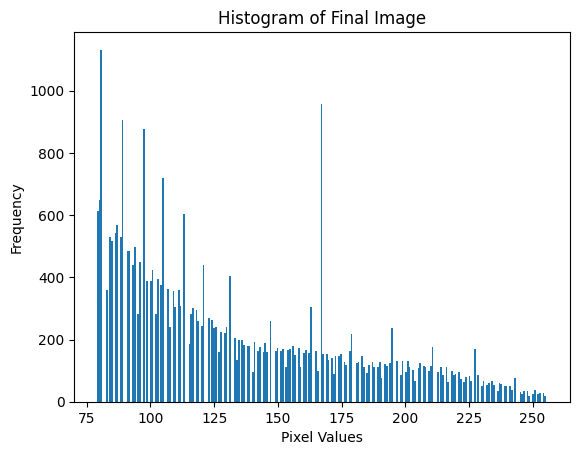

In [ ]:
image_path = "processed_rotated_slices_opencv_threshold/slice_234.png"  # set image path
image_234 = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
hist , bins = np.histogram(image_234.flatten(), 256, [0,256])

plt.hist(image_234.flatten(), 256, [79, 256])
plt.title('Histogram of Final Image')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.show()

# Circles

In [ ]:
image_path = "Patient11_processed_rotated_slices_opencv_threshold/slice_262.png"  # set image path
final_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

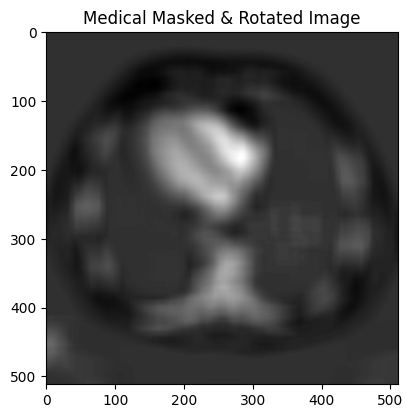

In [ ]:
blurred_image = cv2.blur(final_image,(45,45))

# Create a figure with subplots
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
 
# Add the original image as the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(blurred_image, cmap='gray')
plt.title('Medical Masked & Rotated Image')
plt.show()

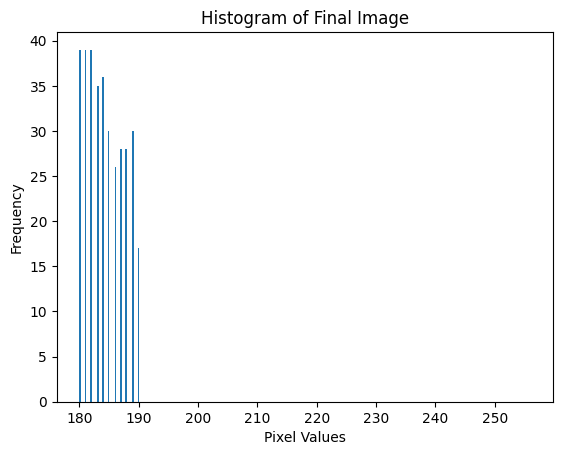

In [ ]:
hist , bins = np.histogram(blurred_image.flatten(), 256, [0,256])

plt.hist(blurred_image.flatten(), 256, [180, 256])
plt.title('Histogram of Final Image')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.show()

In [ ]:
final_thresh_image,thresh1=cv2.threshold(blurred_image,180,200,cv2.THRESH_BINARY)
pixels = 0

for i in range(180,201):
    pixels += hist[i]

print(pixels)

347


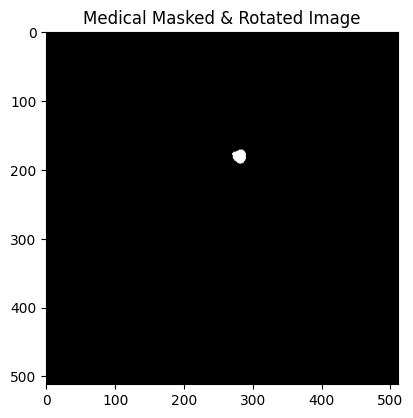

In [ ]:
# Create a figure with subplots
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
 
# Add the original image as the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(thresh1, cmap='gray')
plt.title('Medical Masked & Rotated Image')
plt.show()

In [ ]:
image_path = "Patient11_processed_rotated_slices_opencv_threshold/slice_262.png"  # set image path
final_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

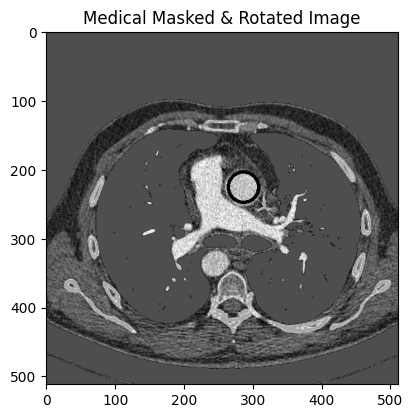

In [ ]:
# Apply Gaussian blur
blurred = cv2.GaussianBlur(final_image, (31, 31), 2)

# Detect circles using HoughCircles
# Adjust these parameters for the specific image
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=100,
                           param1=50, param2=30, minRadius=20, maxRadius=35)

# If circles are detected, draw them
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(final_image, (x, y), r, (0, 255, 0), 4)
# Create a figure with subplots
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
 
# Add the original image as the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(final_image, cmap='gray')
plt.title('Medical Masked & Rotated Image')
plt.show()

In [5]:
# Function to update the circle detection whenever trackbars are used
def detect_circles(x):
    # Get current trackbar positions
    dp = cv2.getTrackbarPos('dp', 'Detected Circles')
    minDist = cv2.getTrackbarPos('minDist', 'Detected Circles')
    param1 = cv2.getTrackbarPos('param1', 'Detected Circles')
    param2 = cv2.getTrackbarPos('param2', 'Detected Circles')
    minRadius = cv2.getTrackbarPos('minRadius', 'Detected Circles')
    maxRadius = cv2.getTrackbarPos('maxRadius', 'Detected Circles')
    
    # Detect circles using the current trackbar values
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=dp, minDist=minDist,
                               param1=param1, param2=param2, 
                               minRadius=minRadius, maxRadius=maxRadius)
    
    # Copy the original image to avoid drawing over it
    displayed_image = image.copy()
    
    # If circles are detected, draw them
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            cv2.circle(displayed_image, (x, y), r, (0, 255, 0), 4)
    
    # Display the image with detected circles
    cv2.imshow('Detected Circles', displayed_image)

# Load the image from file system
image_path = "processed_rotated_slices_opencv_threshold/slice_341.png"  # set image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur
blurred = cv2.GaussianBlur(image, (9, 9), 2)

# Create a window to attach trackbars
cv2.namedWindow('Detected Circles')

# Create trackbars for circle detection parameters
cv2.createTrackbar('dp', 'Detected Circles', 1, 5, detect_circles)
cv2.createTrackbar('minDist', 'Detected Circles', 100, 500, detect_circles)
cv2.createTrackbar('param1', 'Detected Circles', 50, 100, detect_circles)
cv2.createTrackbar('param2', 'Detected Circles', 30, 100, detect_circles)
cv2.createTrackbar('minRadius', 'Detected Circles', 0, 100, detect_circles)
cv2.createTrackbar('maxRadius', 'Detected Circles', 0, 200, detect_circles)

# Initialize the window with the first circle detection
detect_circles(0)

# Wait indefinitely until a key is pressed
cv2.waitKey(0)

# Destroy all windows
cv2.destroyAllWindows()

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'cv::GaussianBlur'


In [ ]:
# If circles are detected, draw them
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(final_image, (x, y), r, (0, 255, 0), 4)

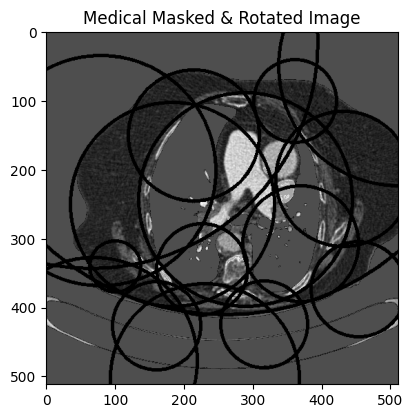

In [ ]:
# Create a figure with subplots
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
 
# Add the original image as the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(final_image, cmap='gray')
plt.title('Medical Masked & Rotated Image')
plt.show()

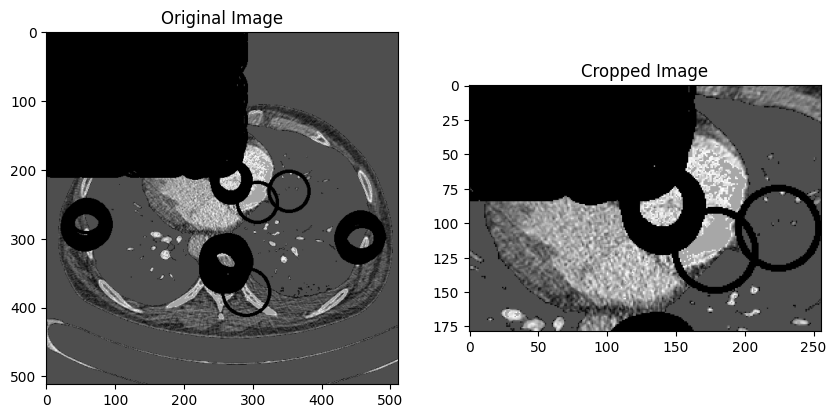

In [ ]:
cropped = final_image.copy()[int(final_image.shape[1]*(start)):int(final_image.shape[1]*(end-0.15)), int(final_image.shape[0]*(start)):int(final_image.shape[0]*end)]
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
#img.copy()[y:y+h, x:x+w]

# Add the original image as the first subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot
plt.imshow(cropped, cmap='gray')
plt.title('Cropped Image')
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(final_image, cmap='gray')
plt.title('Original Image')
plt.show()

# Final 

## Paint final component from found component

<function matplotlib.pyplot.show(close=None, block=None)>

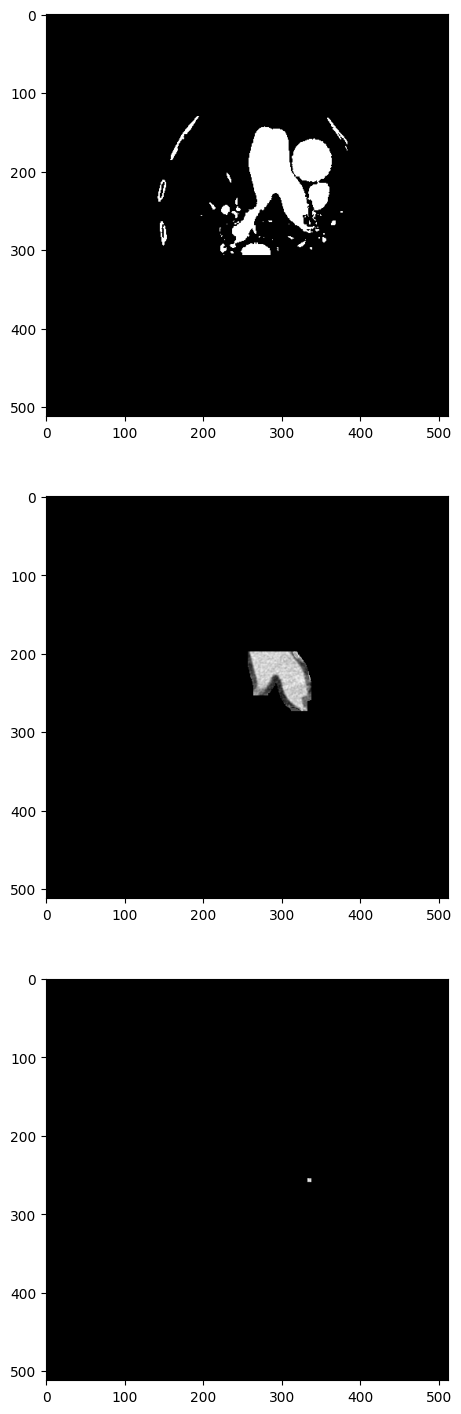

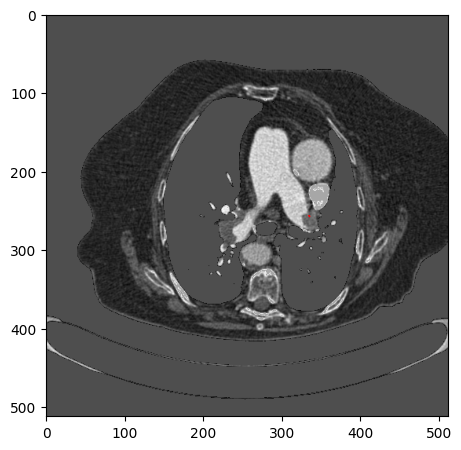

In [ ]:
import numpy as np
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


patient = 6
slice_n = 341

img = cv2.imread(f'Patient_00{patient}/slice_{slice_n}.png',0)

result_image = img.copy()
result_image_2 = img.copy()
#img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 127, 0)
start = 0.25
end = 0.75

upper_left = [int(img.shape[0]*(start)), int(img.shape[1]*(start))]
upper_right = [int(img.shape[0]*end), int(img.shape[1]*(start))]
lower_left = [int(img.shape[0]*(start)), int(img.shape[1]*(end-0.15))]
lower_right = [int(img.shape[0]*end),int(img.shape[1]*(end-0.15))]

for x in range(img.shape[0]):
    for y in range(img.shape[1]):
        if (y not in range(upper_left[0],upper_right[0])) or (x not in range(upper_left[1],lower_left[1])):
            img[x,y] = 0
plt.figure(figsize=(24, 24))


final_thresh_image,thresh1=cv2.threshold(img,115,255,cv2.THRESH_BINARY)
plt.subplot(4,1,1)
plt.imshow(thresh1, cmap='gray')
plt.show
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh1)
largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+1
largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255

kernel = np.ones((3, 3), np.uint8)

# Erosion (y rounds)
erosed_image = cv2.erode(largest_component_mask, kernel, iterations=4)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(erosed_image)
largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+1
largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255

dilated_image = largest_component_mask
dilated_image = cv2.dilate(dilated_image, kernel, iterations=1)


for x in range(0,stats[largest_component_index][1] + int(stats[largest_component_index][3]/2)):
    dilated_image[x,:] = 0

dilated_image = cv2.dilate(dilated_image, kernel, iterations=8)
result_image[dilated_image == 0] = 0

plt.subplot(4,1,2)
plt.imshow(result_image, cmap='gray')
plt.show

blur = cv2.GaussianBlur(result_image,(5,5),0)

new_mask = cv2.inRange(blur, 95, 110)

erosed_image = cv2.erode(new_mask, kernel, iterations=1)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(erosed_image)
largest_component_indices = np.argsort(stats[1:, cv2.CC_STAT_AREA]) + 1
first_two_components_mask = (labels == largest_component_index).astype(np.uint8) * 255

# for index in largest_component_indices:
#     first_two_components_mask[labels == index] = 255

dilated_image = first_two_components_mask


dilated_image = cv2.dilate(dilated_image, kernel, iterations=2)

result_image[dilated_image == 0] = 0
plt.subplot(4,1,3)
plt.imshow(result_image, cmap='gray')
plt.show

img = cv2.imread(f'Patient_00{patient}/slice_{slice_n}.png',1)

start = 0.25
end = 0.75

upper_left = [int(img.shape[0]*(start)), int(img.shape[1]*(start))]
upper_right = [int(img.shape[0]*end), int(img.shape[1]*(start))]
lower_left = [int(img.shape[0]*(start)), int(img.shape[1]*(end-0.15))]
lower_right = [int(img.shape[0]*end),int(img.shape[1]*(end-0.15))]

for x in range(img.shape[0]):
    for y in range(img.shape[1]):
        if (y not in range(upper_left[0],upper_right[0])) or (x not in range(upper_left[1],lower_left[1])):
            img[x,y] = 0
plt.figure(figsize=(24, 24))
blur = cv2.GaussianBlur(result_image,(5,5),0)
new_mask = cv2.inRange(blur, 95, 110)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(new_mask)
stats_4 = 0

for i in range(len(stats)):
    if i == 0:
        continue
    largest_component_mask = (labels == i).astype(np.uint8) * 255
    if first_two_components_mask in largest_component_mask and stats[i][4] > stats_4:
        save_i = i
        stats_4 = stats[i][4]

largest_component_mask = (labels == save_i).astype(np.uint8) * 255

rgb_image = cv2.cvtColor(result_image_2, cv2.COLOR_GRAY2RGB)
colored_image = rgb_image.copy()
color = (255, 0, 0)  # BGR format (red)
img = cv2.imread(f'Patient_00{patient}/slice_{slice_n}.png',0)
img[largest_component_mask == 0] = 0
colored_image[img != 0] = color



plt.subplot(4,1,4)
plt.imshow(colored_image, cmap='gray')
plt.show
# Display or save the resulting image with painted components
# cv2.imwrite(f'{output_folder}/test_image{i}.png', colored_image)
#cv2.imshow('Colored', colored_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

## Edge detection attempt

<function matplotlib.pyplot.show(close=None, block=None)>

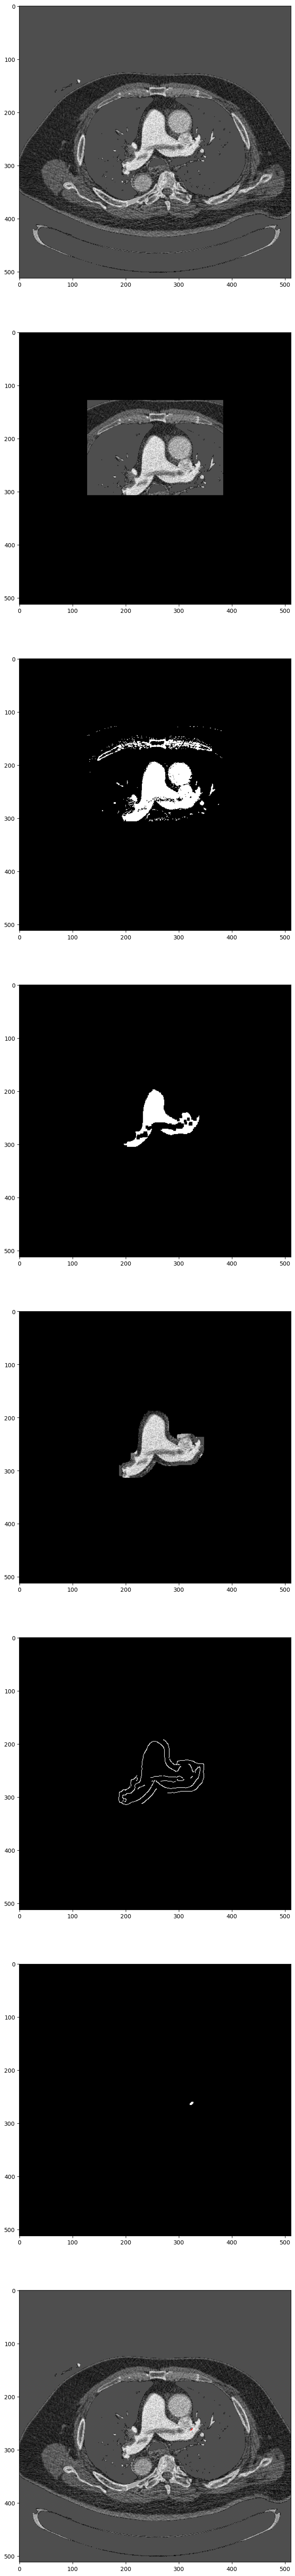

In [ ]:
import numpy as np
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


patient = 24
slice_n = 327

img = cv2.imread(f'Patient_0{patient}/slice_{slice_n}.png',0)

result_image = img.copy()
result_image_2 = img.copy()
#img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 127, 0)
start = 0.25
end = 0.75
plt.figure(figsize=(40, 80))
plt.subplot(8,1,1)
plt.imshow(img, cmap='gray')
plt.show
upper_left = [int(img.shape[0]*(start)), int(img.shape[1]*(start))]
upper_right = [int(img.shape[0]*end), int(img.shape[1]*(start))]
lower_left = [int(img.shape[0]*(start)), int(img.shape[1]*(end-0.15))]
lower_right = [int(img.shape[0]*end),int(img.shape[1]*(end-0.15))]

for x in range(img.shape[0]):
    for y in range(img.shape[1]):
        if (y not in range(upper_left[0],upper_right[0])) or (x not in range(upper_left[1],lower_left[1])):
            img[x,y] = 0

plt.subplot(8,1,2)
plt.imshow(img, cmap='gray')
plt.show
final_thresh_image,thresh1=cv2.threshold(img,115,255,cv2.THRESH_BINARY)

import cv2
import numpy as np
 
 
def nothing(x):
    pass
    

##########


plt.subplot(8,1,3)
plt.imshow(thresh1, cmap='gray')
plt.show
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh1)
largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+1
largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255

kernel = np.ones((3, 3), np.uint8)

# Erosion (y rounds)
erosed_image = cv2.erode(largest_component_mask, kernel, iterations=2)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(erosed_image)
largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+1
largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255

dilated_image = largest_component_mask

plt.subplot(8,1,4)
plt.imshow(dilated_image, cmap='gray')
plt.show

dilated_image = cv2.dilate(dilated_image, kernel, iterations=1)


# # for x in range(0,stats[largest_component_index][1] + int(stats[largest_component_index][3]/2)):
# #     dilated_image[x,:] = 0

dilated_image = cv2.dilate(dilated_image, kernel, iterations=8)
result_image[dilated_image == 0] = 0
plt.subplot(8,1,5)
plt.imshow(result_image, cmap='gray')
plt.show

# cv2.namedWindow('image')
 
# cv2.createTrackbar('T1','image',0,255,nothing)
# cv2.createTrackbar('T2','image',0,255,nothing)
result_image = cv2.GaussianBlur(result_image,(13,13),0)
# while(1):
    # current1 = cv2.getTrackbarPos('T1','image')
    # current2 = cv2.getTrackbarPos('T2','image')
 
# edges = cv2.Canny(result_image,current1,current2,apertureSize = 3)
edges = cv2.Canny(result_image,123,97,apertureSize = 3)
plt.subplot(8,1,6)
plt.imshow(edges, cmap='gray')
plt.show
edges = cv2.dilate(edges, kernel, iterations=2)
edges = cv2.erode(edges, kernel, iterations=1)


num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(edges)
largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+2
largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255
plt.subplot(8,1,7)
plt.imshow(largest_component_mask, cmap='gray')
plt.show
largest_component_mask = cv2.erode(largest_component_mask, kernel, iterations=1)
rgb_image = cv2.cvtColor(result_image_2, cv2.COLOR_GRAY2RGB)
colored_image = rgb_image.copy()
color = (255, 0, 0)  # BGR format (red)
colored_image[largest_component_mask != 0] = color
plt.subplot(8,1,8)
plt.imshow(colored_image, cmap='gray')
plt.show


## Trackbars

### 1

In [2]:
import numpy as np
import cv2

def nothing(x):
    pass


cv2.namedWindow('image')

# cv2.createTrackbar('Block Size', 'image', 9, 1555, nothing)
# cv2.createTrackbar('Constant', 'image', 2, 100, nothing)

cv2.createTrackbar('threshold1', 'image', 0, 255, nothing)
cv2.createTrackbar('threshold2', 'image', 0, 255, nothing)
# cv2.createTrackbar('dilation_iterations', 'image', 0, 15, nothing)


patient = '006'
slice_n = 340

img = cv2.imread(f'patient_{patient}/slice_{slice_n}.png',0)
result_image = img.copy()
result_image_2 = img.copy()

start = 0.25
end = 0.75

upper_left = [int(img.shape[0]*(start)), int(img.shape[1]*(start))]
upper_right = [int(img.shape[0]*end), int(img.shape[1]*(start))]
lower_left = [int(img.shape[0]*(start)), int(img.shape[1]*(end-0.15))]
lower_right = [int(img.shape[0]*end),int(img.shape[1]*(end-0.15))]

for x in range(img.shape[0]):
    for y in range(img.shape[1]):
        if (y not in range(upper_left[0],upper_right[0])) or (x not in range(upper_left[1],lower_left[1])):
            img[x,y] = 0

final_thresh_image,thresh1=cv2.threshold(img,115,255,cv2.THRESH_BINARY)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh1)
largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+1
largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255

kernel = np.ones((3, 3), np.uint8)

# Erosion (y rounds)
erosed_image = cv2.erode(largest_component_mask, kernel, iterations=2)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(erosed_image)
largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+1
largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255

dilated_image = largest_component_mask
dilated_image = cv2.dilate(dilated_image, kernel, iterations=8)

result_image[dilated_image == 0] = 0

blur = cv2.GaussianBlur(result_image,(5,5),0)


while True:
    # dilation_iterations = cv2.getTrackbarPos('dilation_iterations', 'image')

    # dilated_image = cv2.dilate(dilated_image, kernel, iterations=dilation_iterations)

    # result_image[dilated_image == 0] = 0

    # blur = cv2.GaussianBlur(result_image,(5,5),0)


    # block_size = cv2.getTrackbarPos('Block Size', 'image')
    # constant = cv2.getTrackbarPos('Constant', 'image')

    threshold2 = cv2.getTrackbarPos('threshold2', 'image')
    threshold1 = cv2.getTrackbarPos('threshold1', 'image')

    # is_odd = False
    # if block_size % 2 == 1:
    #     is_odd = True

    # # Only update the block size if it's an odd number
    # if is_odd:
    #     # Apply adaptive thresholding
    #     new_mask = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, constant)

    new_mask = cv2.inRange(blur, threshold1, threshold2)


    erosed_image = cv2.erode(new_mask, kernel, iterations=1)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(erosed_image)
    largest_component_indices = np.argsort(stats[1:, cv2.CC_STAT_AREA])[::-1][:2] + 1
    first_two_components_mask = np.zeros_like(labels, dtype=np.uint8)

    for index in largest_component_indices:
        first_two_components_mask[labels == index] = 255

    dilated_image = first_two_components_mask

    dilated_image = cv2.dilate(dilated_image, kernel, iterations=2)

    new_mask_2 = cv2.inRange(result_image_2, threshold1, threshold2)
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(new_mask_2)
    largest_component_indices = np.argsort(stats[1:, cv2.CC_STAT_AREA])[::-1][:2] + 1
    first_two_components_mask = np.zeros_like(labels, dtype=np.uint8)

    rgb_image = cv2.cvtColor(result_image_2, cv2.COLOR_GRAY2RGB)
    colored_image = rgb_image.copy()
    color = (0, 0, 255)

    colored_image[dilated_image != 0] = color
    result = np.hstack((rgb_image,colored_image))
    cv2.imshow('image', result)

    # Check for ESC key press to exit
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break

cv2.destroyAllWindows()

### 2

In [1]:
import numpy as np
import cv2



def nothing(x):
    pass

patient = 24
slice_n = 330

cv2.namedWindow('image')
cv2.createTrackbar('T1','image',0,255,nothing)
cv2.createTrackbar('T2','image',0,255,nothing)
img = cv2.imread(f'Patient_0{patient}/slice_{slice_n}.png',0)

result_image = img.copy()
result_image_2 = img.copy()
#img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 127, 0)
start = 0.25
end = 0.75
 
upper_left = [int(img.shape[0]*(start)), int(img.shape[1]*(start))]
upper_right = [int(img.shape[0]*end), int(img.shape[1]*(start))]
lower_left = [int(img.shape[0]*(start)), int(img.shape[1]*(end-0.15))]
lower_right = [int(img.shape[0]*end),int(img.shape[1]*(end-0.15))]

for x in range(img.shape[0]):
    for y in range(img.shape[1]):
        if (y not in range(upper_left[0],upper_right[0])) or (x not in range(upper_left[1],lower_left[1])):
            img[x,y] = 0

 
final_thresh_image,thresh1=cv2.threshold(img,115,255,cv2.THRESH_BINARY)

 
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh1)
largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+1
largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255

kernel = np.ones((3, 3), np.uint8)

# Erosion (y rounds)
erosed_image = cv2.erode(largest_component_mask, kernel, iterations=2)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(erosed_image)
largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+1
largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255

dilated_image = largest_component_mask

  
dilated_image = cv2.dilate(dilated_image, kernel, iterations=1)


dilated_image = cv2.dilate(dilated_image, kernel, iterations=8)
result_image[dilated_image == 0] = 0
 

result_image = cv2.GaussianBlur(result_image,(13,13),0)
while(1):
    current1 = cv2.getTrackbarPos('T1','image')
    current2 = cv2.getTrackbarPos('T2','image')
    
    edges = cv2.Canny(result_image,current1,current2,apertureSize = 3)
    # edges = cv2.Canny(result_image,90,102,apertureSize = 3)

    edges = cv2.dilate(edges, kernel, iterations=2)
    edges = cv2.erode(edges, kernel, iterations=1)


    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(edges)
    largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+2
    largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255
 
    largest_component_mask = cv2.erode(largest_component_mask, kernel, iterations=1)
    rgb_image = cv2.cvtColor(result_image_2, cv2.COLOR_GRAY2RGB)
    colored_image = rgb_image.copy()
    color = (0, 0, 255)  # BGR format (red)
    colored_image[largest_component_mask != 0] = color
 
    result = np.hstack((rgb_image,colored_image))
    cv2.imshow('image',result)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
cv2.destroyAllWindows()


## The chosen one

<function matplotlib.pyplot.show(close=None, block=None)>

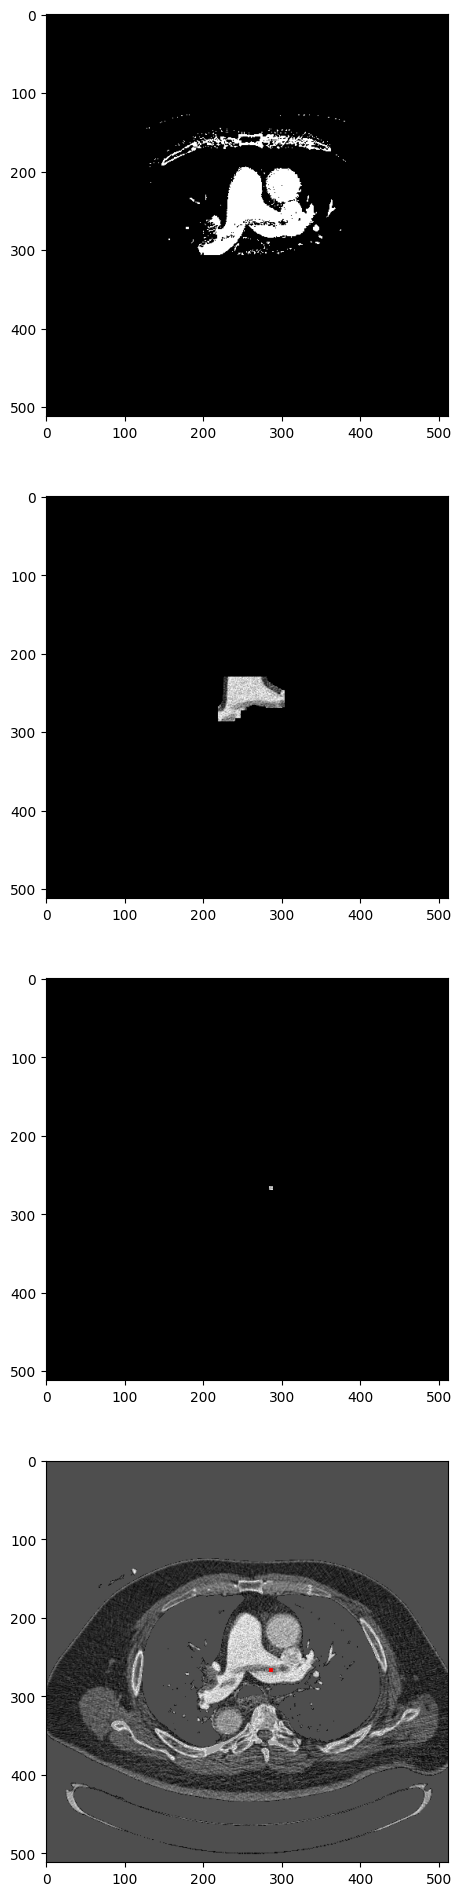

In [ ]:
import numpy as np
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


patient = 24
slice_n = 327

img = cv2.imread(f'Patient_0{patient}/slice_{slice_n}.png',0)

result_image = img.copy()
result_image_2 = img.copy()
#img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 127, 0)
start = 0.25
end = 0.75

upper_left = [int(img.shape[0]*(start)), int(img.shape[1]*(start))]
upper_right = [int(img.shape[0]*end), int(img.shape[1]*(start))]
lower_left = [int(img.shape[0]*(start)), int(img.shape[1]*(end-0.15))]
lower_right = [int(img.shape[0]*end),int(img.shape[1]*(end-0.15))]

for x in range(img.shape[0]):
    for y in range(img.shape[1]):
        if (y not in range(upper_left[0],upper_right[0])) or (x not in range(upper_left[1],lower_left[1])):
            img[x,y] = 0
plt.figure(figsize=(24, 24))


final_thresh_image,thresh1=cv2.threshold(img,115,255,cv2.THRESH_BINARY)
plt.subplot(4,1,1)
plt.imshow(thresh1, cmap='gray')
plt.show
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh1)
largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+1
largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255

kernel = np.ones((3, 3), np.uint8)

# Erosion (y rounds)
erosed_image = cv2.erode(largest_component_mask, kernel, iterations=4)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(erosed_image)
largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA])+1
largest_component_mask = (labels == largest_component_index).astype(np.uint8) * 255

dilated_image = largest_component_mask
dilated_image = cv2.dilate(dilated_image, kernel, iterations=1)


for x in range(0,stats[largest_component_index][1] + int(stats[largest_component_index][3]/2)):
    dilated_image[x,:] = 0

dilated_image = cv2.dilate(dilated_image, kernel, iterations=8)
result_image[dilated_image == 0] = 0

plt.subplot(4,1,2)
plt.imshow(result_image, cmap='gray')
plt.show

blur = cv2.GaussianBlur(result_image,(5,5),0)

new_mask = cv2.inRange(blur, 95, 110)

erosed_image = cv2.erode(new_mask, kernel, iterations=1)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(erosed_image)
largest_component_indices = np.argsort(stats[1:, cv2.CC_STAT_AREA]) + 1
first_two_components_mask = (labels == largest_component_index).astype(np.uint8) * 255

# for index in largest_component_indices:
#     first_two_components_mask[labels == index] = 255

dilated_image = first_two_components_mask


dilated_image = cv2.dilate(dilated_image, kernel, iterations=2)

result_image[dilated_image == 0] = 0
plt.subplot(4,1,3)
plt.imshow(result_image, cmap='gray')
plt.show
rgb_image = cv2.cvtColor(result_image_2, cv2.COLOR_GRAY2RGB)
colored_image = rgb_image.copy()
color = (255, 0, 0)  # BGR format (red)
colored_image[dilated_image != 0] = color


plt.subplot(4,1,4)
plt.imshow(colored_image, cmap='gray')
plt.show
# Display or save the resulting image with painted components
# cv2.imwrite(f'{output_folder}/test_image{i}.png', colored_image)
#cv2.imshow('Colored', colored_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()